In [1]:
import numpy as np
import matplotlib.pyplot as plt
from posixpath import split
import scienceplots
plt.style.use(['science','ieee'])
import os
import pandas as pd

In [2]:
class tdCARS:
  def __init__(self, cars_main_file):
    #LODA DATA FROM FILES
    directory,filename = split(cars_main_file)
    self.sample = filename[0:-4]
    cars_data = np.loadtxt(open(cars_main_file, "rb"), delimiter="\t", skiprows=0)
    if not len(cars_data[0])==4:
      raise Exception("Invalid file! Select CARS data file without '_Spectra', '_Notes', '_Floor' after sample name.")
    cars_spectra = np.loadtxt(open(f"{directory}/{self.sample}_Spectra.dat", "rb"), delimiter="\t", skiprows=0)
    self.cars_floor = np.loadtxt(open(f"{directory}/{self.sample}_Floor.dat", "rb"), delimiter="\t", skiprows=0)
    notes_file = open(f"{directory}/{self.sample}_Notes.dat", "r").readlines()
    self.cars_notes = [notes_file[i].split('\n')[0].split('\t') for i in range(len(notes_file))]

    #EXTRACT/CONDITION DATA
    self.td = cars_data[:, 0]
    self.sig = cars_data[:, 1]
    self.sig_int = cars_data[:,2]
    self.att = cars_data[:,3]
    spectra = cars_spectra[:,1:-1]

    self.wl1,self.wl2,self.wl3,self.mono = float(self.cars_notes[7][1]),float(self.cars_notes[8][1]),float(self.cars_notes[6][1]),float(self.cars_notes[9][1])
    self.start_px,self.end_px = int(float(self.cars_notes[17][1].split()[0])), int(float(self.cars_notes[17][1].split()[2]))
    self.exp_date = directory.split('/')[-1]

    rCnt,cCnt = len(spectra[:,0]),len(spectra[0,:])
    att2d = np.zeros([rCnt,cCnt])
    floor2d = np.zeros([rCnt,cCnt])
    curr_att = 1
    curr_floor_idx = 0
    for i in range(rCnt):
      if not curr_att == self.att[i]:
        curr_att = self.att[i]
        curr_floor_idx += 1
      else:
        pass
      att2d[i,:] = np.ones(cCnt)*curr_att
      floor2d[i,:] = self.cars_floor[curr_floor_idx,:]

    self.spectra = np.multiply((spectra-floor2d),att2d)
    self.spectra_sc_full = self.spectra
    self.X_full,self.Y_full = np.arange(1,2049),self.td[:-1]
########################################### GET SPECTRA CONTOUR ####################################################
  def get_spectra_contour(self,*args):
    #SPECTRA CONTOUR
    if len(args)==0:
      zoom = False
    else:
      zoom = True

    plt.figure(figsize=(4,3),dpi=150)
    #self.X_full,self.Y_full = np.arange(1,2049),self.td[:-1]
    self.spectra_sc_full = self.spectra+np.abs(np.min(self.spectra))
    X,Y,Z = self.X_full, self.Y_full, np.log(self.spectra_sc_full)

    if zoom:
      X,Y = self.X_full[(self.X_full<self.px_max)&(self.X_full>self.px_min)],self.Y_full[(self.Y_full<self.td_max)&(self.Y_full>self.td_min)]
      spectra_sc_crop = self.spectra_sc_full[(self.Y_full<self.td_max)&(self.Y_full>self.td_min),:]
      spectra_sc_crop = spectra_sc_crop[:,(self.X_full<self.px_max)&(self.X_full>self.px_min)]
      Z = np.log(spectra_sc_crop)
    plt.contourf(X, Y, Z)
    plt.colorbar()
    plt.title(f"CARS signal for delay vs pixel for {self.sample}")
    plt.xlabel("$pixel$")
    plt.ylabel("$t_d [fs]$")
    plt.grid()
    plt.close()
    return X,Y,Z
########################################### GET SPECTRA AT td ####################################################
  def get_spectra_at_td(self,td_target):
    #PLOT SPECTRA AT td
    res = self.spectra_sc_full[np.where(self.Y_full>=td_target)[0][0],:]
    plt.figure(figsize=(5,3),dpi=150)
    #plt.yscale("log")
    plt.plot(self.X_full[1:], res[1:], 'o', mfc='none', mec='k', mew=0.5, ms=2)#px1 has unusually high signal???
    plt.title(f"$CARS signalvs pixel @ t_d = {self.Y_full[self.Y_full>=td_target][0]:.0f}fs for {self.sample}$")
    plt.xlabel("$pixel$")
    plt.ylabel("$Signal [counts]$")
    plt.grid()
    plt.close()
    return self.X_full[1:], res[1:]
########################################### GET TRANSIENT AT PIXEL ####################################################
  def get_transient_at_pixel(self,px_target):
    #PLOT TRANSIENT AT pixel
    res = self.spectra_sc_full[:,np.where(self.X_full>=px_target)[0][0]]
    plt.figure(figsize=(5,3),dpi=150)
    plt.yscale("log")
    plt.plot(self.Y_full, res, '-o',color = 'k', mfc='none', mec='k', mew=0.5, ms=2, lw=0.5)
    plt.title(f"$CARS signalvs dellay @ pixel = {self.X_full[self.X_full>=px_target][0]:.0f} for {self.sample}$")
    plt.xlabel("$delay [fs]$")
    plt.ylabel("$Signal [counts]$")
    plt.grid()
    plt.close()
    return self.Y_full, res
########################################### PLOT CARS ####################################################
  def plot_cars(self):
    #PLOT CARS
    plt.figure(figsize=(5,3),dpi=150)
    plt.yscale("log")
    plt.plot(self.td, self.sig/np.min(self.sig), 'o', mfc='none', mec='k', mew=0.5, ms=2)
    plt.title(f"$CARS signal vs delay for {self.sample}$")
    plt.xlabel("$t_d [fs]$")
    plt.ylabel("$Signal [counts]$")
    plt.grid()
    plt.show()
#################################### PIXEL TO WAVELENGTH CONVERSION #############################################
  def px2wavelength(self):
    gd=1200#grating density[groves/mm]
    cs=2048#chip size
    ps=14e-3#pixel spacing [mm]
    c1 = np.radians(10.63*2)/2
    a = np.arcsin((self.mono*gd*1e-6)/(np.cos(c1)*2)) - c1
    b = a + np.radians(10.63*2) + np.radians(-5.5)
    h = np.sin(np.radians(-5.5))*318.719
    l = np.cos(np.radians(-5.5))*318.719
    arr = np.zeros(cs)
    for i in range(cs):
        m = b-np.arctan(((((cs/2)-i+1)*ps)+h)/l)
        arr[i] = (np.sin(m)+np.sin(a))*(1000000/gd)
    return arr
#################################### PIXEL TO WAVENUMBER CONVERSION #############################################
  def px2wavenumber(self):
    wl = self.px2wavelength()
    return 1E7*(1/wl-1/self.wl3)
########################################### OPO CONVOLUTION ####################################################
  @staticmethod
  def opo_conv(wl1,sig1,wl2,sig2):
    #pick the longest array
    wl_long,wl_short,sig_long,sig_short = wl2,wl1,sig2,sig1
    if len(wl1)>len(wl2):
        wl_long,wl_short,sig_long,sig_short = wl1,wl2,sig1,sig2
    N_max, N_min = len(wl_long), len(wl_short)
    N = N_max + N_min - 1
    conv_wl,conv_sig = np.zeros(N),np.zeros(N)
    for i in range(N):
      idx_1,idx_2,len_12 = 0,0,0
      if i<N_max-1:
        idx_1, idx_2 = N_max-1-i, 0
        if i+1<N_min:
          len_12 = i+1
        else:
          len_12 = N_min
      else:
        idx_1, idx_2 = 0, i-(N_max-1)
        len_12 = N-i
      conv_wl[i] = np.abs(1/np.mean(wl_long[idx_1:idx_1+len_12])-1/np.mean(wl_short[idx_2:idx_2+len_12]))
      conv_sig[i] = np.sum(np.multiply(sig_long[idx_1:idx_1+len_12],sig_short[idx_2:idx_2+len_12]))
    return conv_wl,conv_sig
########################################### GET OPO CONVOLUTION ####################################################
  def get_OPO_convoltion(self):
    del_wl, fwhm = 10,10
    opo1_wl = np.arange(self.wl1-del_wl, self.wl1+del_wl, 0.5)
    opo1_sig = np.exp(-4*np.log(2)*(opo1_wl-self.wl1)**2/fwhm**2)
    opo2_wl = np.arange(self.wl2-del_wl, self.wl2+del_wl, 0.5)
    opo2_sig = np.exp(-4*np.log(2)*(opo2_wl-self.wl2)**2/fwhm**2)

    wl_conv,sig_conv = self.opo_conv(opo1_wl,opo1_sig,opo2_wl,opo2_sig)

    plt.plot(wl_conv*1E7,sig_conv/max(sig_conv),label = "From OPOs")
    plt.title("OPO1, OPO2 Convolution Amplitude vs Wavenumber")
    plt.xlabel("Wavenumber $[cm^{-1}]$")
    plt.ylabel("Normalized Amplitude $[a.u.]$")
    plt.grid()
    plt.legend()
    plt.close()
    return wl_conv*1E7, sig_conv/max(sig_conv)
########################################### GET CARS ####################################################
  def get_CARS(self,T2,nuR,A1,tmin,tmax,floor):
    '''
    T2,nuR and A1 are 1D arrays with first element reffering to the non-reasonant signal
    and rest of the elements reffering to the reasonant modes.(ex: if only one mode exsits,
    array has 2 elements. get_CARS([10,400],[800,800],[1E26,1E24],-1500,5000,100))
    Set T2[10,xx,xx,...] and nuR[xx,xx,xx,...] according to target mode.
    Calculate or estimate floor and retrive tmin, tmax from data.
    For A1, always set A1[0] after optimizing A[1],A[2], etc. Get the pure exponential
    sections (straight lines in log plot) align with data using correcponding A1[x] values.
    '''
    wl1,wl2,wl3,tp1,tp2,tp3,step = self.wl1,self.wl2,self.wl3,250,250,120,5
    c = 3E-5 #speed of light [cm/fs]
    w1,w2,w3 = 2*np.pi*c*1E7/wl1, 2*np.pi*c*1E7/wl2, 2*np.pi*c*1E7/wl3 #frequencies [1/fs]
    wt = w1-w2 #target frequency [1/fs]
    a12 = -2*np.log(2)*(1/tp1**2+1/tp2**2) # Coefficient for gaussian envelop [1/fs/fs]
    a3 = -4*np.log(2)/tp3**2 # Coefficient for gaussian envelop [1/fs/fs]

    wR = 2*np.pi*c*nuR #Raman mode frequency [1/fs]
    wr = wt-wR #detuning freq [1/fs]
    b2 = -(1/T2+1j*wr) #Coefficients for dephasing amplitude [1/fs]

    #E1, E2 Convolution
    t = np.arange(tmin,tmax,step)

    #Heaviside-step function
    lim=tp1*5
    ts = np.arange(-lim,lim,step)

    Q = np.zeros(len(t))

    for i in range(len(t)):
      ls = int(2*lim/step)
      cnt = int((t[i]+lim)/step)
      if (t[i]<-lim):
        hs = np.zeros(ls)
      elif (t[i]>lim):
        hs = np.ones(ls)
      else:
        hs = np.concatenate((np.ones(cnt), np.zeros(ls-cnt)),axis=None)
      tmp = 0
      for j in range(len(A1)):
        tmp += A1[j]*np.exp(b2[j]*(t[i]-ts))
      F = hs*tmp*np.exp(a12*ts**2)
      Q[i] = (1E-15*step*np.abs(np.trapz(F)))**2

    td = np.arange(tmin+5*tp3,tmax-5*tp3,step)
    S = np.zeros(len(td))

    for i in range(len(td)):
      I3 = np.sqrt(-a3)*np.exp(a3*(t-td[i])**2)
      F = Q*I3
      S[i] = 1E-15*step*np.trapz(F)+floor
    return td,S
########################################### get_T2 ####################################################
  def get_T2(self,td1,td2):
    x,y = self.td[(self.td>td1)&(self.td<td2)],np.log(self.sig[(self.td>td1)&(self.td<td2)])
    p,c = np.polyfit(x, y, 1,cov='unscaled')
    T2 = 2*np.abs(1/p[0])
    sig_T2 = np.abs(1/(p[0]-np.sqrt(c[0,0]))-1/(p[0]+np.sqrt(c[0,0])))/2
    A = np.exp(p[1])
    #print(f"T2 = {T2[1]:.1f} \u00B1 {sig_T2:.1f} [fs]")
    return T2,sig_T2,A
########################################### get_linewidth ####################################################
  @staticmethod
  def get_linewidth(T2,sig_T2):
    lnWdth = 2/(T2*2*np.pi*2.99792458E-5)
    sig_lnWdth = lnWdth*sig_T2/T2
    return lnWdth, sig_lnWdth
########################################### get_mode ####################################################
  def get_mode(self,td,sig_wl3=0,sig_as=0):
    x,y = self.get_spectra_at_td(td)
    px = np.where(np.max(y[self.start_px:self.end_px])==y)[0][0]
    wl_as = self.px2wavelength()[px]
    mode = 1E7*(1/wl_as-1/self.wl3)
    return mode#, 1E7*np.sqrt(sig_as**2/wl_as**4+sig_wl3**2/self.wl3**4)
########################################### get_att_margins ####################################################
  def get_att_margins(self):
    curr_att = self.att[0]
    att_list = []
    for i in range(len(self.att)):
      if (curr_att != self.att[i]):
        curr_att = self.att[i]
        att_list.append(curr_att)
    att_indices = [[],[],[],[],[],[],[],[],[]]
    for i in range(len(att_list)):
      for j in range(len(self.att)):
        if (self.att[j] == att_list[i]):
          att_indices[i].append(True)
        else:
          att_indices[i].append(False)
    return att_list, att_indices
########################################### correct_att ####################################################
  def correct_att(self,old_att,new_att):
    for i in range(len(self.att)):
      if (self.att[i] == old_att):
        self.sig[i] = self.sig[i]*new_att/old_att
########################################### correct_att ####################################################


In [3]:
#OPEN MULTIPLE FILES#
image_dir = "images/"
directory = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/"
subDirs = os.listdir(directory)
x = np.array([]);y = np.array([]);yerr = np.array([]);lbls=[];i=0
modes = np.array([]);modes2 = np.array([])
for subDir in subDirs:
  files = os.listdir(directory+"/"+subDir)
  for file in files:
    if not (file.endswith("_Notes.dat") or file.endswith("_Spectra.dat") or file.endswith("_Floor.dat")):
      filePath = directory + subDir + "/" + file
      cars = tdCARS(filePath)
      t2,sig_T2,A = cars.get_T2(500,2000)
      T2 = np.array([10,t2])
      x=np.append(x,i);y=np.append(y,T2[1]);yerr=np.append(yerr,sig_T2);i+=1;lbls.append(file)
      cars.wl3 = cars.wl3 - 5
      modes = np.append(modes,cars.get_mode(750, ))
      modes2 = np.append(modes2,1E7/cars.wl1-1E7/cars.wl2)

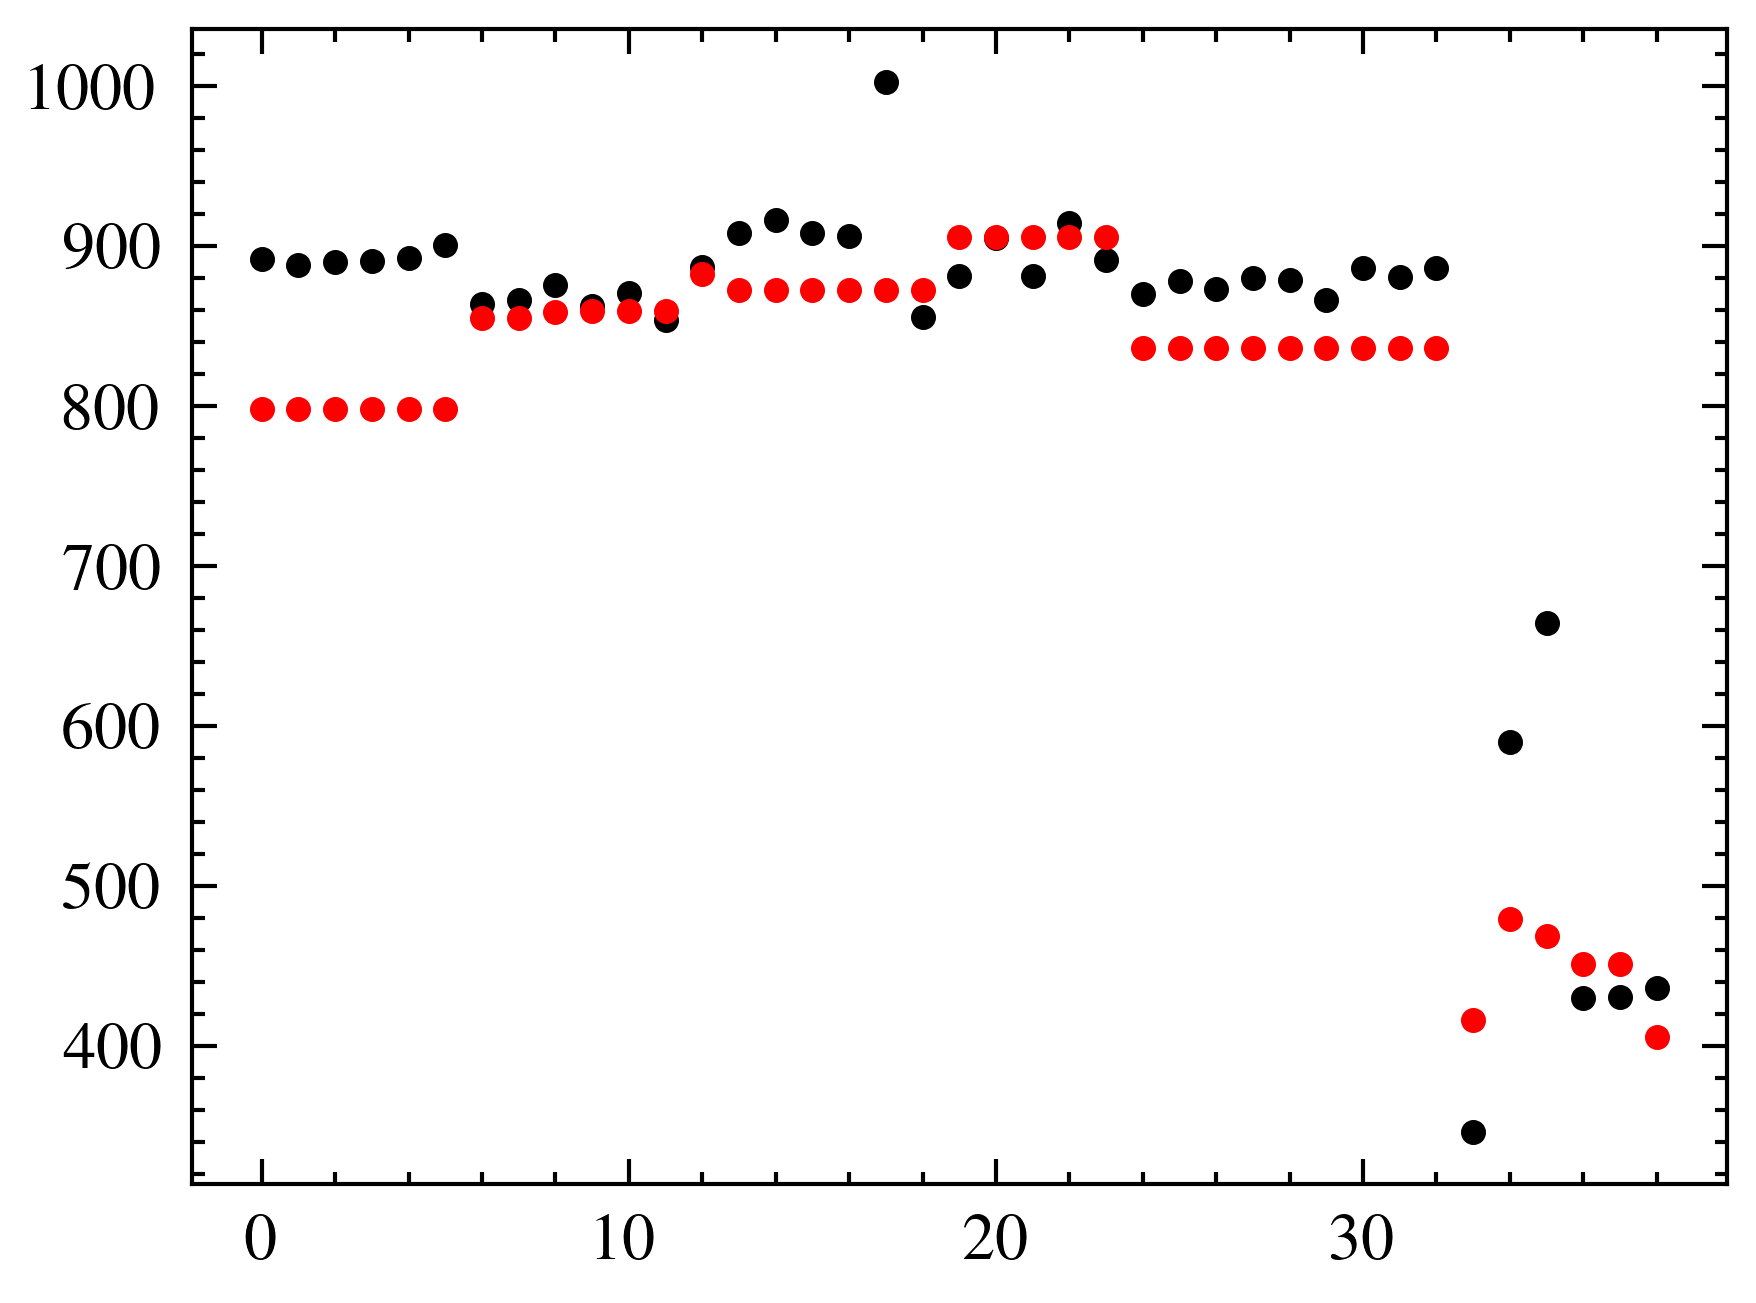

In [4]:
plt.plot(x,modes,'o',ms=2)
plt.plot(x,modes2,'or',ms=2)

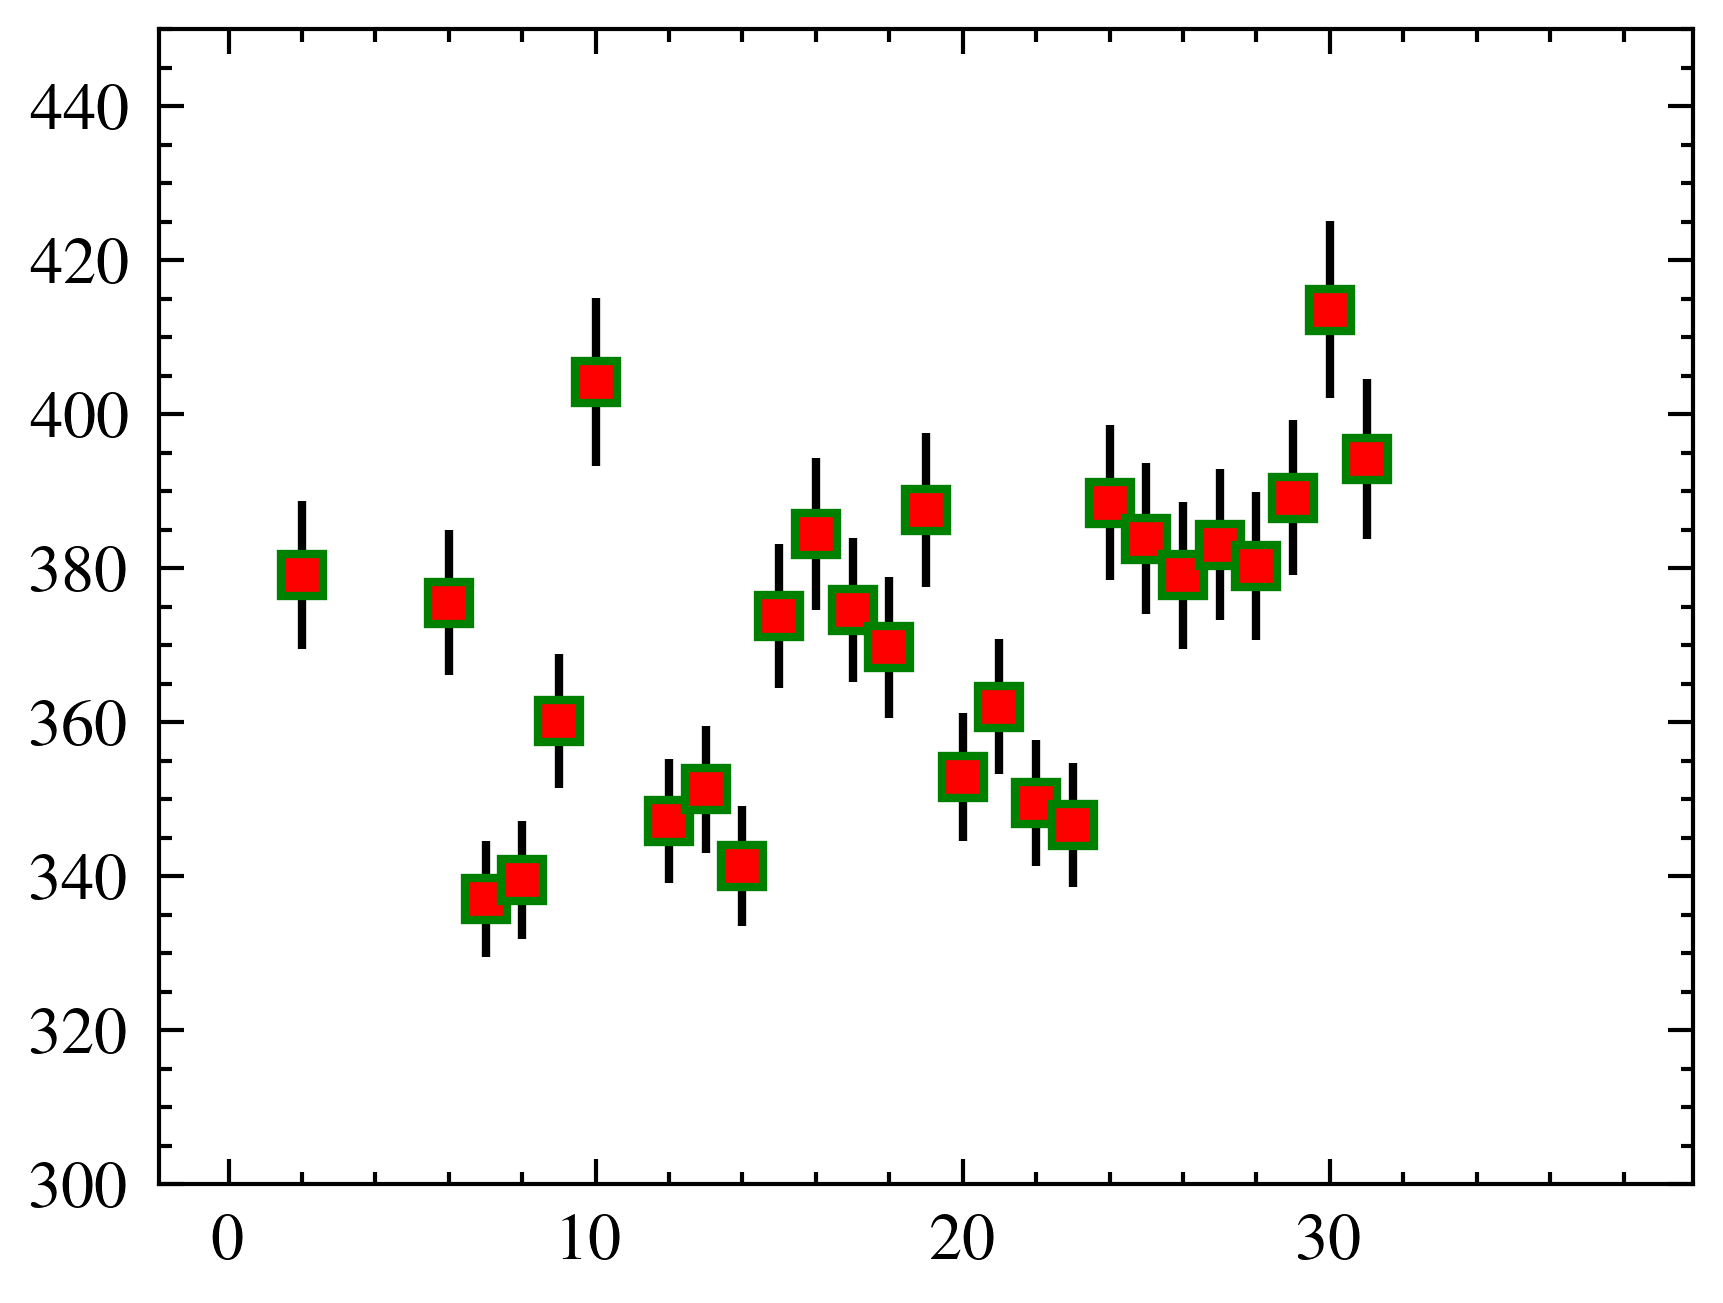

In [5]:
plt.errorbar(x, y, yerr, marker='s', mfc='red',mec='green', ms=5, mew=1, linestyle='')
#plt.xticks(x, lbls, rotation ='vertical')
#plt.xlim([20,-1])
plt.ylim([300,450])
plt.show()

In [6]:
files = ['Aug_05/LNB_1','Aug_05/LNB_2','Aug_05/LNB_3','Aug_06/LNB_1','Aug_06/LNB_2','Aug_06/LNB_3','Aug_07/LNB_1','Aug_07/LNB_2','Aug_07/LNB_3']
labels = ['X(Z,YZ)X','X(Z,Y)X','X(Z,Z)X','x(y,yz)x','Z(Y,XY)Z','Z(Y,XY)Z','Z(Y,XY)Z','Z(X,Y)Z','Z(X,X)Z']
tLim = [[400,1600],[500,1600],[500,1200],[500,2000],[400,2000],[500,2000],[400,2400],[400,1800],[500,1300]]
amps = [[3E25,1E23],[6E24,4E22],[7E24,7E21],[1.2E26,1.5E24],[1.5E26,7.5E23],[1.5E26,7.5E23],[1E26,5E23],[2E25,1.1E23],[4E24,1.8E22]]
cols = [(0, 0.4470, 0.7410),(0.8500, 0.3250, 0.0980),(0.9290, 0.6940, 0.1250),(0.4940, 0.1840, 0.5560),(0.4660, 0.6740, 0.1880),(0.3010, 0.7450, 0.9330),(0.6350, 0.0780, 0.1840),(0,0,0),(1,0,0)]

C:\Users\dinus\AppData\Local\Temp\ipykernel_36212\575763968.py:210: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q[i] = (1E-15*step*np.abs(np.trapz(F)))**2
C:\Users\dinus\AppData\Local\Temp\ipykernel_36212\575763968.py:218: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  S[i] = 1E-15*step*np.trapz(F)+floor


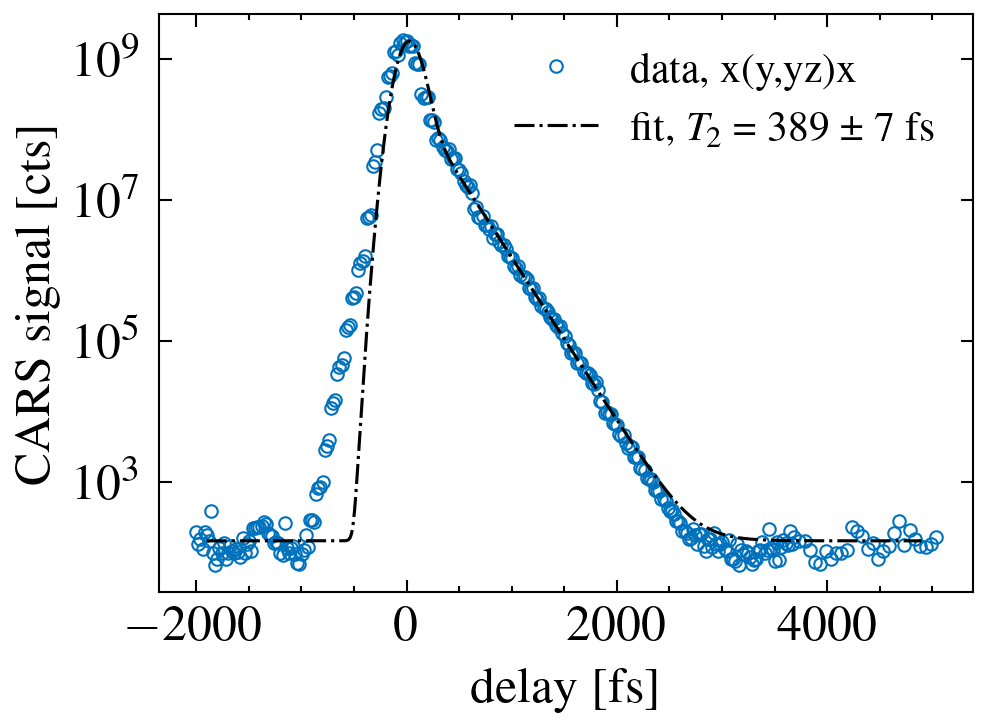

In [7]:
dirPath = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/"
plt.figure(figsize=(3.5,2.5),dpi=300)
font = {'size'   : 12}
plt.rc('font', **font)
x = np.arange(0,9,1)
y = np.zeros(len(x))
yerr = np.zeros(len(x))
for i in [3]:
  filein = dirPath+files[i]+'.dat'
  cars = tdCARS(filein)
  #Estimate T2
  t2,sig_T2,A = cars.get_T2(tLim[i][0],tLim[i][1])
  #y[i], yerr[i] = t2, sig_T2
  T2 = np.array([10,t2])
  #Estimate floor
  floor = np.mean(cars.sig[cars.td<-1000])
  #Estimate target wavenumber
  target_nuR = 1E7*np.abs(1/cars.wl1-1/cars.wl2)
  #Fit CARS
  nuR,A1,tmin,tmax = np.array([target_nuR,target_nuR]),amps[i],-2000,5000
  td_fit,sig_fit = cars.get_CARS(T2,nuR,A1,tmin-500,tmax+500,floor)

  plt.plot(cars.td, cars.sig,'o',mew=0.5,ms=3,mfc='none',mec = cols[0], label=f"data, {labels[i]}")
  #plt.plot(td_fit,sig_fit,'-.',color='k',lw=0.75, label=f"fit, $T_2$ = {T2[1]:.0f} \u00B1 {sig_T2:.0f} fs")
  plt.plot(td_fit,sig_fit,'-.',color='k',lw=0.75, label=f"fit, $T_2$ = {389} \u00B1 {7} fs")
  plt.xlabel("delay [fs]");plt.ylabel("CARS signal [cts]")
#plt.xticks([0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600],
#['0','200','400','600','800','1000','1200','1400','1600','1800','2000','2200','2400','2600'], rotation ='vertical')
plt.yscale("log");plt.legend(prop={'size': 10});plt.show()

C:\Users\dinus\AppData\Local\Temp\ipykernel_36212\575763968.py:210: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Q[i] = (1E-15*step*np.abs(np.trapz(F)))**2
C:\Users\dinus\AppData\Local\Temp\ipykernel_36212\575763968.py:218: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  S[i] = 1E-15*step*np.trapz(F)+floor


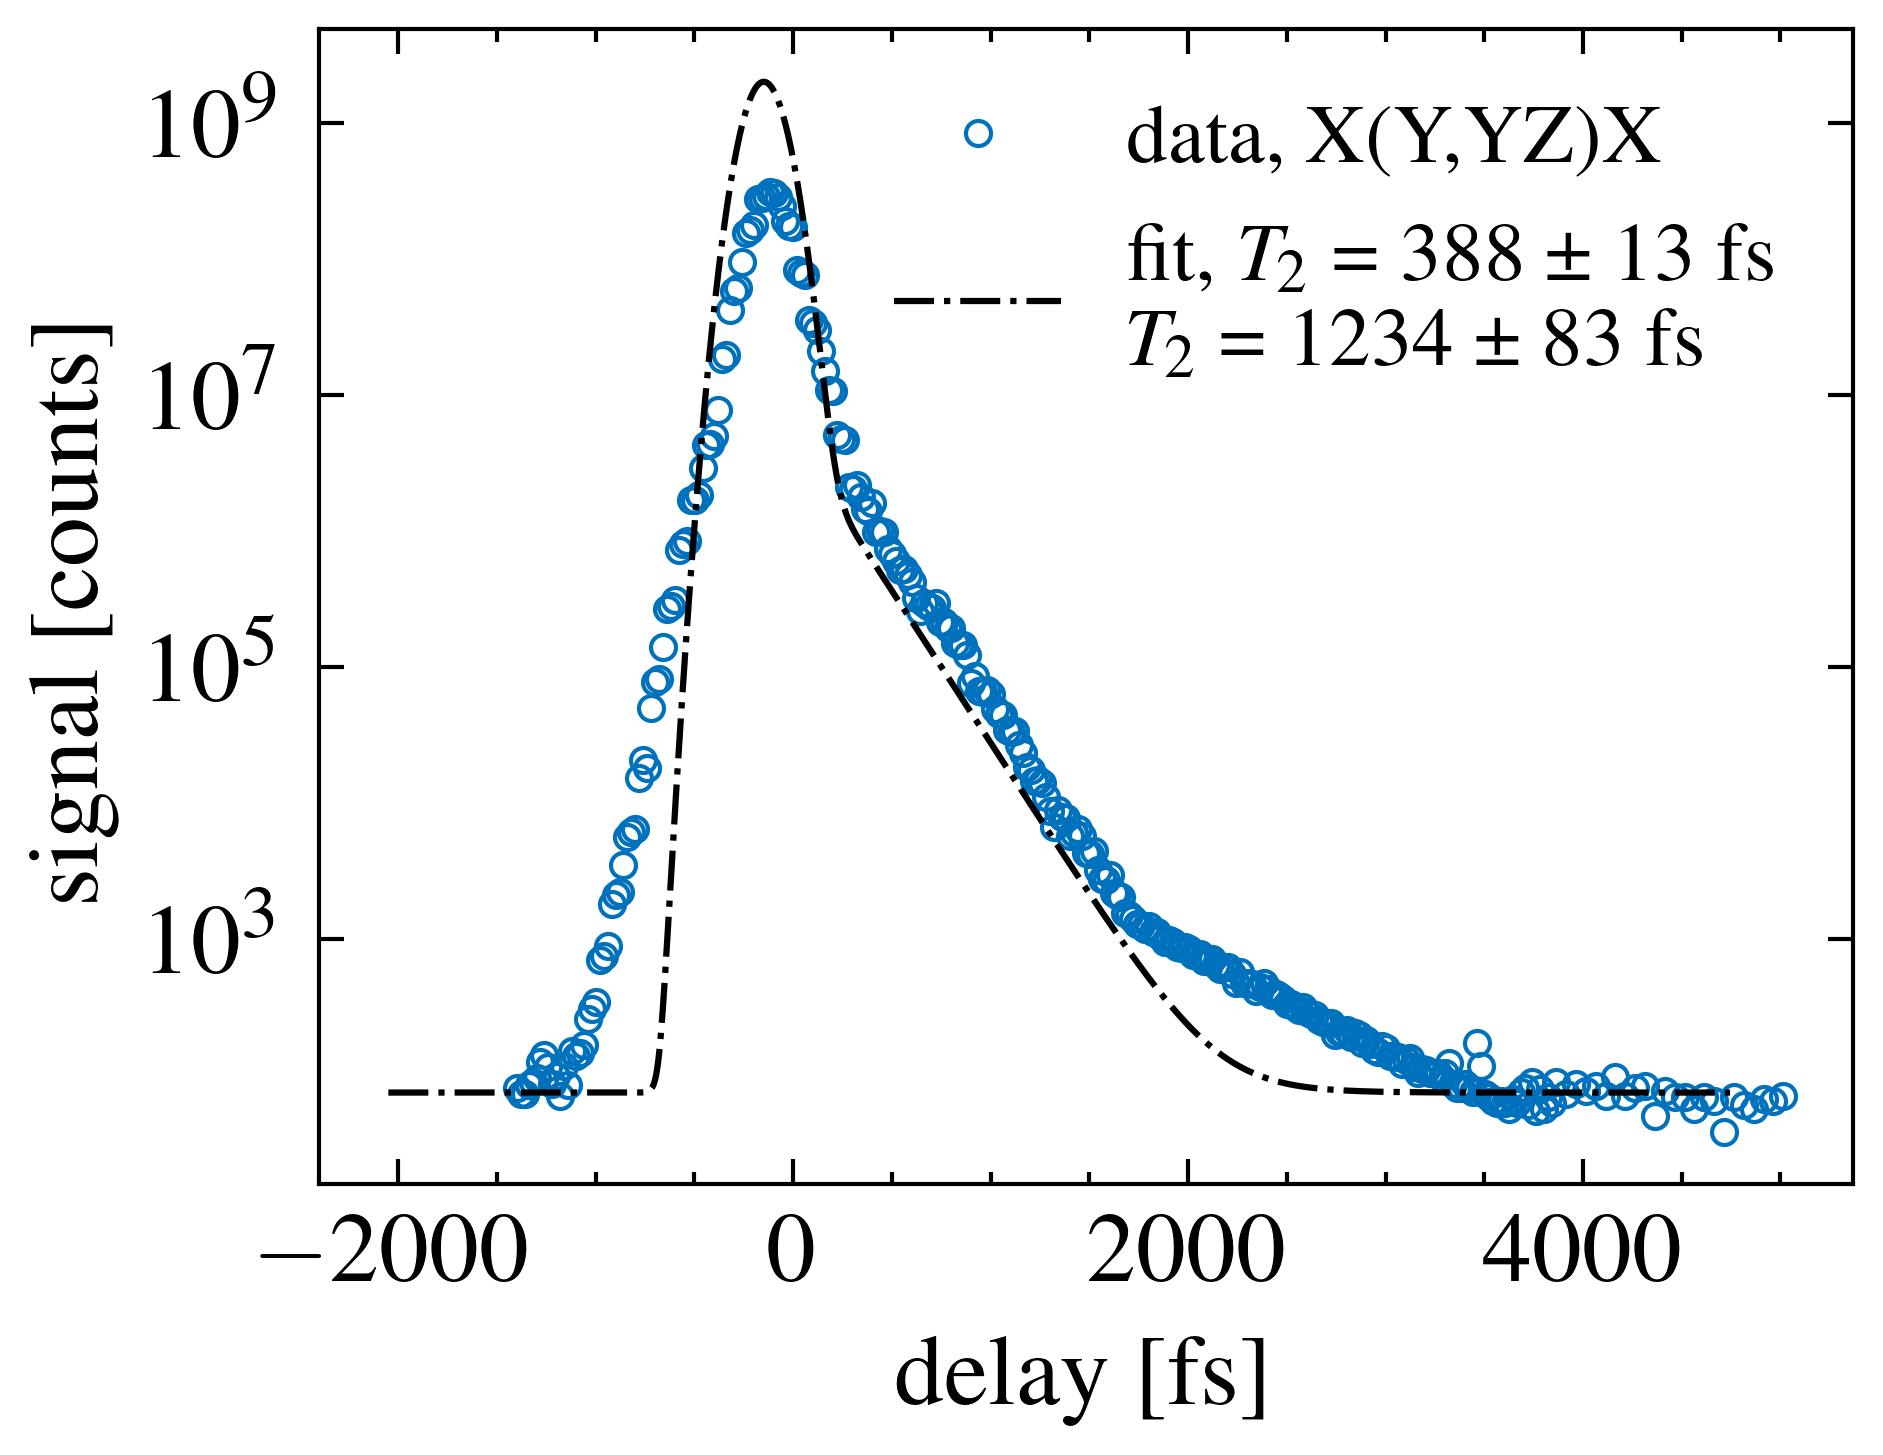

In [8]:
filein = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/Jul_30/LNB_1.dat"
cars = tdCARS(filein)
cars.correct_att(10,30)
cars.correct_att(100,120)
cars.correct_att(1000,650)
cars.correct_att(100000,120*650)
#Estimate T2
t21,sig_T21,A1 = cars.get_T2(500,1750)
t22,sig_T22,A2 = cars.get_T2(1750,3500)
#y[i], yerr[i] = t2, sig_T2
T2 = np.array([10,t21,t22])
#Estimate floor
floor = np.mean(cars.sig[cars.td<-1000])
#Estimate target wavenumber
target_nuR = 1E7*np.abs(1/cars.wl1-1/cars.wl2)
#Fit CARS
nuR,A1,tmin,tmax = np.array([905,950,1330]),np.array([5E25,4E23,9E25]),-2000,5000
td_fit,sig_fit = cars.get_CARS(T2,nuR,A1,tmin-500,tmax+500,floor-50)

plt.plot(cars.td, cars.sig,'o',mew=0.5,ms=3,mfc='none',mec = cols[0], label=f"data, X(Y,YZ)X")
plt.plot(td_fit-150,sig_fit,'-.',color='k',lw=0.75, label=f"fit, $T_2$ = {T2[1]:.0f} \u00B1 {sig_T21:.0f} fs \n $T_2$ = {T2[2]:.0f} \u00B1 {sig_T22:.0f} fs")
plt.xlabel("delay [fs]");plt.ylabel("signal [counts]")
plt.yscale("log");plt.legend(prop={'size': 10});plt.show()

In [9]:
tdCARS.get_linewidth(365,5)

(29.089520322609015, 0.3984865797617673)

In [10]:
lw = np.array([]);SIG_lw = np.array([])
for i in range(len(files)):
  filein = dirPath+files[i]+'.dat'
  cars = tdCARS(filein)
  #Estimate T2
  t2,sig_T2,A = cars.get_T2(tLim[i][0],tLim[i][1])
  LW_,SIG_LW_ = tdCARS.get_linewidth(t2,sig_T2)
  m1,_ = cars.get_mode(tLim[i][0],5,5)
  m2,_ = cars.get_mode(tLim[i][1],5,5)
  lw = np.append(lw,LW_)
  SIG_lw = np.append(SIG_lw,SIG_LW_)

TypeError: cannot unpack non-iterable numpy.float64 object

ValueError: 'x' and 'y' must have the same size

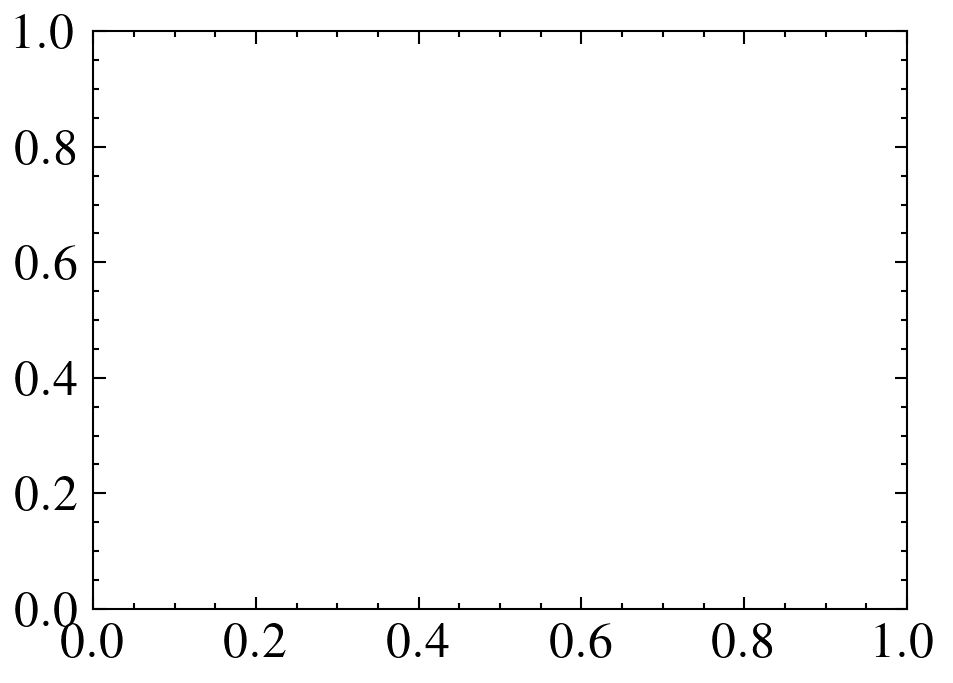

In [ ]:
plt.figure(figsize=(3.5,2.5),dpi=300)
plt.errorbar(x, lw, SIG_lw, marker='s', mfc='red',
         mec='green', ms=5, mew=1, linestyle='')
plt.xticks(x, labels, rotation =90)
plt.xlabel(r"configuration")
plt.ylabel(r"linewidth [cm$^{-1}$]")
plt.show()

In [46]:
freq = np.array([159,166,311,488,576,646])
modes = ['TO1','LO1', 'TO2', 'LO2','TO3', 'LO3']
bi_freq = np.array([])
bi_modes = []
found_freq = np.array([])

t_freq = 790
rng = 20

for i in range(len(freq)):
    for j in range(len(freq)):
       bi_freq = np.append(bi_freq, freq[i]+freq[j])
       bi_modes.append(modes[i] + '+' + modes[j])
for i in range(len(bi_freq)):
    if (bi_freq[i]<(t_freq+rng) and bi_freq[i]>(t_freq-rng) and (bi_freq[i] not in found_freq)):
        found_freq = np.append(found_freq, bi_freq[i])
        print(f'{bi_freq[i]}->{bi_modes[i]}')

805.0->TO1+LO3
799.0->TO2+LO2
